##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install pandas 
#%pip install numpy
#%pip install matplotlib
#%pip install sckit-learn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [24]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from datetime import date
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file
pd.options.display.max_rows = 10000

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## Data Cleaning / EDA

In [3]:
train_df = pd.read_parquet(filepath)
print(train_df.shape)

(17992, 304)


In [4]:
train_df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


- remove None/NaN
- change min_occ_date and cltdob_fix format
- categorical variable to do one-hot encoding: race_desc, ctrycode_desc, clttype 

In [5]:
def race_encode(data):
    race_encoder = OneHotEncoder()
    race_onehotarray = race_encoder.fit_transform(data[['race_desc']]).toarray()
    races = [f'{race}' for race in race_encoder.categories_[0]]
    data[races] = race_onehotarray
    data = data.drop(columns='race_desc', errors='ignore')
    return data


def clttype_encode(data):
    clttype_encoder = OneHotEncoder()
    clttype_onehotarray = clttype_encoder.fit_transform(data[['clttype']]).toarray()
    clttypes = [f'{clttype}' for clttype in clttype_encoder.categories_[0]]
    data[clttypes] = clttype_onehotarray
    data = data.drop(columns='clttype', errors='ignore')
    return data

def stat_encode(data):
    stat_encoder = OneHotEncoder()
    stat_onehotarray = stat_encoder.fit_transform(data[['stat_flag']]).toarray()
    stats = [f'{stat}' for stat in stat_encoder.categories_[0]]
    data[stats] = stat_onehotarray
    data = data.drop(columns='stat_flag', errors='ignore')
    return data

def main_encode(data):
    data = race_encode(data)
    data = clttype_encode(data)
    data = stat_encode(data)
    return data

In [6]:
def calculate_duration(past):
    today = date.today()
    return today.year - past.year - ((today.month, today.day) < (past.month, past.day))

def cleaning_dates(data):
    data['min_occ_date']= pd.to_datetime(data['min_occ_date'])
    data['min_occ_dur'] = data['min_occ_date'].apply(calculate_duration)

    data['cltdob_fix']= pd.to_datetime(data['cltdob_fix'])
    data['age'] = data['cltdob_fix'].apply(calculate_duration)

    data = data.drop(columns=['min_occ_date', 'cltdob_fix'], errors='ignore')
    return data

In [7]:
def data_cleaning(data):
    cols_to_drop = ["clntnum", "giclaim_cnt_success", "recency_giclaim_success", "giclaim_cnt_unsuccess", "recency_giclaim_unsuccess", "flg_gi_claim_29d435_ever", "flg_gi_claim_058815_ever", "flg_gi_claim_42e115_ever", "flg_gi_claim_856320_ever",
                    "flg_hlthclaim_14cb37_ever", "flg_hlthclaim_839f8a_ever",
                    "is_valid_dm", "is_valid_email", "is_housewife_retiree", "is_dependent_in_at_least_1_policy", "f_ever_declined_la"]
    cols2 = ["ape_gi_42e115", "ape_ltc_1280bf", "ape_inv_dcd836", "ape_lh_d0adeb", "ape_gi_a10d1b", "ape_gi_29d435", "ape_gi_058815",
                    "sumins_grp_22decf", "sumins_gi_a10d1b", "sumins_gi_29d435", "sumins_lh_e22a6a", "sumins_gi_856320", "sumins_grp_94baec", "sumins_gi_058815", "sumins_grp_e04c3a", "sumins_32c74c",
                    "prempaid_gi_42e115", "prempaid_ltc_1280bf", "prempaid_inv_dcd836", "prempaid_lh_d0adeb", "prempaid_gi_a10d1b", "prempaid_gi_29d435", "prempaid_gi_058815",
                    "ape_d0adeb", "f_hold_gi", "sumins_gi", "prempaid_d0adeb", "prempaid_gi", 'ape_gi_856320', 'ape_32c74c', 'sumins_gi_42e115', 'sumins_ltc_1280bf', 'sumins_inv_dcd836', 'sumins_lh_d0adeb', 'prempaid_gi_856320', 'prempaid_32c74c', 'ape_gi',
                    'f_hold_d0adeb', 'sumins_e22a6a', 'sumins_d0adeb', 'lapse_ape_ltc_1280bf', 'f_ever_bought_ltc_1280bf', 'n_months_last_bought_d0adeb', 'f_ever_bought_d0adeb', 'lapse_ape_32c74c', 'lapse_ape_lh_d0adeb', 'lapse_ape_inv_dcd836',
                    'n_months_last_bought_lh_d0adeb', 'n_months_last_bought_inv_dcd836', 'n_months_last_bought_ltc_1280bf', 'f_ever_bought_32c74c', 'f_ever_bought_lh_d0adeb', 'f_ever_bought_inv_dcd836']
    data.replace(to_replace=['None'], value=np.nan, inplace=True) # convert 'None' to NA to drop if needed
    data.replace(to_replace=[None], value=np.nan, inplace=True)
    data.dropna(subset=['min_occ_date', 'cltdob_fix'], inplace=True) # drop NA since 10 and 20 rows respectively
    data["f_purchase_lh"] = np.where(data["f_purchase_lh"] == 1, 1, 0) # convert to either 0 or 1
    data = data.drop(columns=cols_to_drop, errors='ignore') 
    data = data.drop(columns=cols2, errors='ignore') # initial EDA showed None for all rows

    data.loc[data.race_desc.isnull(), 'race_desc'] = 'Others'
    data["ctrycode_desc"] = np.where(data["ctrycode_desc"] == 'Singapore', 1, 0)
    data["cltsex_fix"] = np.where(data["cltsex_fix"] == 'Female', 0, 1)
    data = data.rename(columns={'ctrycode_desc': 'flg_sg', 'cltsex_fix': 'flg_male'})
    data['flg_substandard'] = np.where(data['flg_substandard'] == 1, 1, 0)
    data['annual_income_est'] = data['annual_income_est'].replace({'C.60K-100K': 60000, 'D.30K-60K' : 30000, 'A.ABOVE200K' : 200000, 'B.100K-200K' : 100000, 'E.BELOW30K': 0})
    data['hh_size_est'] = data['hh_size_est'].replace({'>4': 4})
    
    data = main_encode(data)
    data = cleaning_dates(data)

    data.fillna(0, inplace=True)

    data = data.astype(float)
    data=(data-data.min())/(data.max()-data.min())
    data.fillna(0, inplace=True)

    return data


In [8]:
train_df = data_cleaning(train_df)
print(train_df.head)
print('Proportion of likelihood buy', train_df['f_purchase_lh'].value_counts())

<bound method NDFrame.head of        flg_sg  flg_male  flg_substandard  flg_is_borderline_standard  \
19550     1.0       0.0              0.0                         0.0   
4600      1.0       1.0              0.0                         0.0   
13337     1.0       1.0              0.0                         0.0   
15074     1.0       0.0              0.0                         0.0   
19724     1.0       0.0              0.0                         0.0   
...       ...       ...              ...                         ...   
11284     1.0       1.0              0.0                         0.0   
11964     1.0       1.0              0.0                         0.0   
5390      1.0       0.0              0.0                         0.0   
860       1.0       1.0              0.0                         0.0   
15795     1.0       1.0              0.0                         0.0   

       flg_is_revised_term  flg_is_rental_flat  flg_has_health_claim  \
19550                  0.0       

In [9]:
for i in train_df:
    print(i, train_df[i].unique())

flg_sg [1. 0.]
flg_male [0. 1.]
flg_substandard [0. 1.]
flg_is_borderline_standard [0. 1.]
flg_is_revised_term [0. 1.]
flg_is_rental_flat [0. 1.]
flg_has_health_claim [0. 1.]
flg_has_life_claim [0. 1.]
flg_gi_claim [0. 1.]
flg_is_proposal [0. 1.]
flg_with_preauthorisation [0. 1.]
flg_is_returned_mail [0. 1.]
is_sg_pr [1. 0.]
is_class_1_2 [1. 0.]
hh_20 [0.26325411 0.2797075  0.11334552 0.00182815 0.20840951 0.25228519
 0.23948812 0.42595978 0.19926874 0.10603291 0.19561243 0.2285192
 0.         0.12431444 0.1535649  0.18647166 0.10968921 0.40402194
 0.13162706 0.2047532  0.18281536 0.10786106 0.29067642 0.16453382
 0.16087751 0.14808044 0.21206581 0.14990859 0.39122486 0.16819013
 0.17915905 0.34917733 0.05850091 0.08043876 0.21937843 0.18464351
 0.24680073 0.17184644 0.08775137 0.3857404  0.05301645 0.2321755
 0.12248629 0.06398537 0.13893967 0.12797075 0.15722121 0.06032907
 0.06764168 0.27056673 0.26508227 0.04753199 0.34003656 0.07312614
 0.52650823 0.19744059 0.29798903 0.40036563 

In [26]:
corr = train_df.corr().abs()

s = corr.unstack()
so = s.sort_values(kind="quicksort")
(so[-1400:-280])

prempaid_grp_6fc3e6                sumins_507c37                        0.661803
sumins_507c37                      prempaid_grp_6fc3e6                  0.661803
ape_grp_6fc3e6                     sumins_507c37                        0.661803
sumins_507c37                      ape_grp_6fc3e6                       0.661803
n_months_last_bought_grp_caa6ff    sumins_839f8a                        0.662971
sumins_839f8a                      n_months_last_bought_grp_caa6ff      0.662971
n_months_last_bought_grp_caa6ff    prempaid_grp_caa6ff                  0.664977
prempaid_grp_caa6ff                n_months_last_bought_grp_caa6ff      0.664977
n_months_last_bought_grp_caa6ff    ape_grp_caa6ff                       0.664977
ape_grp_caa6ff                     n_months_last_bought_grp_caa6ff      0.664977
ACTIVE                             n_months_last_bought_32c74c          0.665061
n_months_last_bought_32c74c        ACTIVE                               0.665061
sumins_grp_70e1dd           

In [15]:
print(corr[abs(corr).gt(0.7).any(axis=1)])

                              flg_sg  flg_male  flg_substandard  \
flg_sg                      1.000000 -0.010180         0.004736   
flg_male                   -0.010180  1.000000        -0.000791   
flg_substandard             0.004736 -0.000791         1.000000   
flg_is_borderline_standard  0.013166 -0.010635         0.091339   
flg_is_revised_term         0.002765  0.002057         0.006125   
...                              ...       ...              ...   
ACTIVE                      0.021530  0.042024         0.037801   
LAPSED                     -0.022047 -0.039826        -0.038872   
MATURED                     0.002765 -0.019573         0.006125   
min_occ_dur                -0.010567  0.087526         0.091122   
age                        -0.028817 -0.046516         0.028824   

                            flg_is_borderline_standard  flg_is_revised_term  \
flg_sg                                        0.013166             0.002765   
flg_male                             

## Split into Train/Validation/Test sets & Oversampling

In [9]:
from sklearn.model_selection import train_test_split

y = train_df['f_purchase_lh']
X = train_df.drop('f_purchase_lh', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print('Training data counts: ', X_train.shape)
print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())
print('Validation data counts: ', X_valid.shape)
print('Proportion of purchase likelihood  in validation data: \n', y_valid.value_counts())
print('Testing data counts: ', X_test.shape)
print('Proportion of purchase likelihood in testing data: \n', y_test.value_counts())

Training data counts:  (12212, 290)
Proportion of purchase likelihood in training data: 
 0.0    11742
1.0      470
Name: f_purchase_lh, dtype: int64
Validation data counts:  (3054, 290)
Proportion of purchase likelihood  in validation data: 
 0.0    2933
1.0     121
Name: f_purchase_lh, dtype: int64
Testing data counts:  (2694, 290)
Proportion of purchase likelihood in testing data: 
 0.0    2577
1.0     117
Name: f_purchase_lh, dtype: int64


In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

print('Proportion of purchase likelihood in training data: \n', y_train.value_counts())

Proportion of purchase likelihood in training data: 
 0.0    11742
1.0    11742
Name: f_purchase_lh, dtype: int64


## Modelling

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Function to evaluate the model and print metrics
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_valid)

    # Print accuracy
    print('Accuracy on validation set: {:.8f}'.format(accuracy_score(y_valid, y_pred)))

    # Print confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print('True Neg:', tn, '\t' ,'False Pos:', fp)
    print('False Neg:', fn, '\t', 'True Pos:', tp)

    # Print precision and recall
    print('Precision on validation set: {:.8f}'.format(precision_score(y_valid, y_pred)))
    print('Recall on validation set: {:.8f}'.format(recall_score(y_valid, y_pred)))
    print('F1-Score on validation set: {:.8f}'.format(f1_score(y_valid, y_pred)))


    # Plot ROC Curve
    try:
        class_prob = model.predict_proba(X_valid)
        preds = class_prob[:, 1]
        fpr, tpr, threshold = roc_curve(y_valid, preds)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='Model (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("Model does not have predict_proba method. ROC curve not plotted.")


## Logistic Regression

Accuracy on validation set: 0.76424361
True Neg: 2257 	 False Pos: 676
False Neg: 44 	 True Pos: 77
Precision on validation set: 0.10225764
Recall on validation set: 0.63636364
F1-Score on validation set: 0.17620137


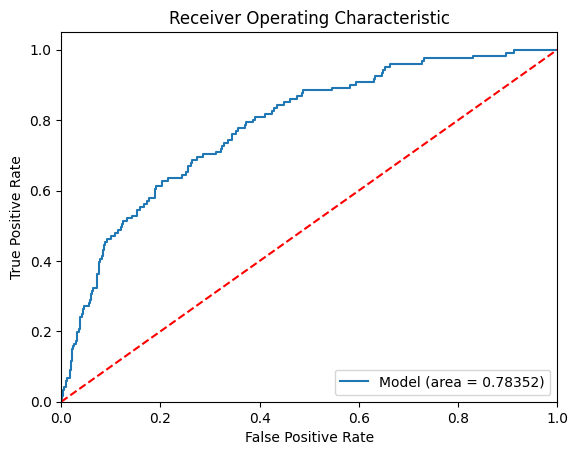

In [15]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter=1000)
evaluate_model(logReg, X_train, y_train, X_valid, y_valid)

### Weighted Logistic Regression

In [ ]:
logwt_trainaccuracy = np.zeros(shape=(11))
logwt_testaccuracy = np.zeros(shape=(11))

for weight in range(0, 11):
  wt = 0.1*weight
  wts = {0:wt, 1:1-wt}
  logwt = LogisticRegression(class_weight = wts)
  logwt.fit(X_train,y_train)
  logwt_trainaccuracy[weight]= logwt.score(X_train, y_train)
  logwt_testaccuracy[weight]= logwt.score(X_valid, y_valid)

depths = range(0, 11)

# Plot and label the training and validation loss values
plt.plot(depths, logwt_trainaccuracy, label='Training Accuracy')
plt.plot(depths, logwt_testaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

Tried weighted logistic regression but it predicts the class with higher weights. (ie. sharp drop after 6 => class weights {0: 0.6, 1: 0.4} which causes the model to predict all as 0 and we have about 1/3 33% of 0 classes)

### Feature Selection Logistic Regression

In [16]:
from sklearn.feature_selection import RFE

train_acc = np.zeros(shape=(20))
valid_acc = np.zeros(shape=(20))


for i in range(1, 20):
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_train,y_train)
    train_acc[i - 1]= rfe.score(X_train, y_train)
    valid_acc[i - 1]= rfe.score(X_valid, y_valid)

depths = range(20)

# Plot and label the training and validation loss values
plt.plot(depths, train_acc, label='Training Accuracy')
plt.plot(depths, valid_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
d = valid_acc.argmax(axis=0) + 1
print(d)
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=d)
evaluate_model(rfe, X_train, y_train, X_valid, y_valid)

print(X_train.columns[rfe.support_])


## Decision Tree

Accuracy on validation set: 0.93418468
True Neg: 2837 	 False Pos: 96
False Neg: 105 	 True Pos: 16
Precision on validation set: 0.14285714
Recall on validation set: 0.13223140
F1-Score on validation set: 0.13733906


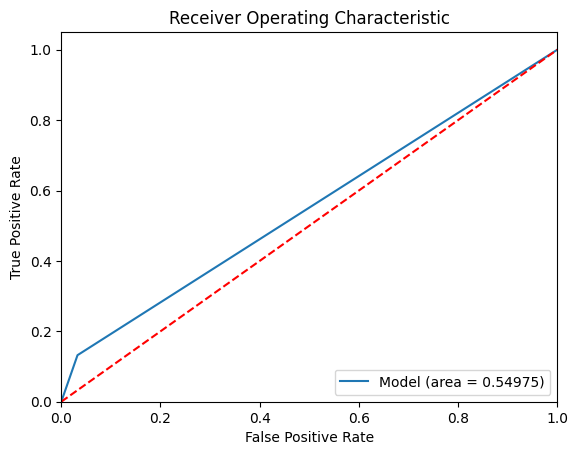

In [17]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
evaluate_model(tree, X_train, y_train, X_valid, y_valid)

### Max-Depth Decision Tree

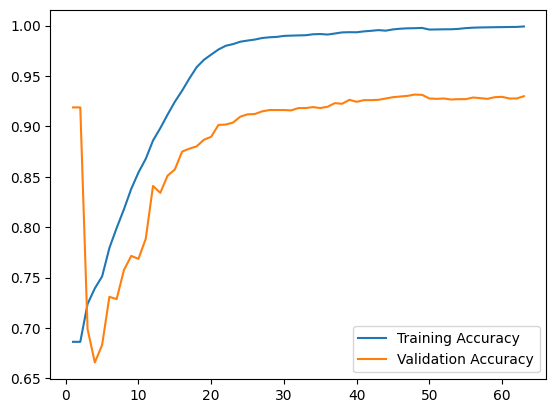

In [18]:
tree_trainaccuracy = np.zeros(shape=(tree.tree_.max_depth))
tree_validaccuracy = np.zeros(shape=(tree.tree_.max_depth))
for max_d in range(1,tree.tree_.max_depth+1):
  tree2 = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  tree2.fit(X_train,y_train)
  tree_trainaccuracy[max_d - 1]= tree2.score(X_train, y_train)
  tree_validaccuracy[max_d - 1]= tree2.score(X_valid, y_valid)

depths = range(1, tree.tree_.max_depth+1)

# Plot and label the training and validation loss values
plt.plot(depths, tree_trainaccuracy, label='Training Accuracy')
plt.plot(depths, tree_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

48
Accuracy on validation set: 0.92894565
True Neg: 2813 	 False Pos: 120
False Neg: 97 	 True Pos: 24
Precision on validation set: 0.16666667
Recall on validation set: 0.19834711
F1-Score on validation set: 0.18113208


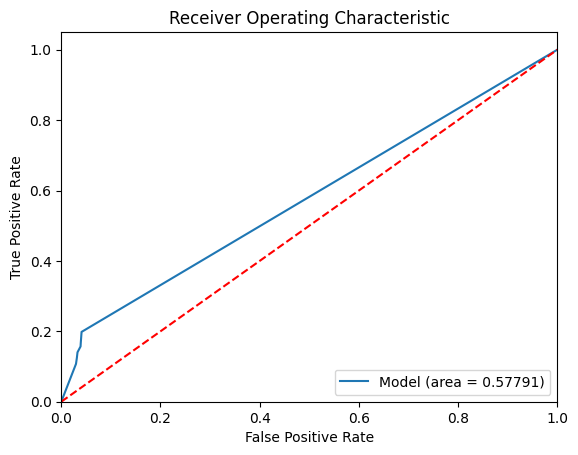

In [19]:
# max_depth = sqrt(d)
d = tree_validaccuracy.argmax(axis=0) + 1
print(d)
tree_depth = DecisionTreeClassifier(max_depth=d)
evaluate_model(tree_depth, X_train, y_train, X_valid, y_valid)

Validation accuracy peaks at 34.

### Feature Selection Decision Tree

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(DecisionTreeClassifier())
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

newX_train = X_train[selected_feat]
newX_valid = X_valid[selected_feat]

dt_feat = DecisionTreeClassifier()
evaluate_model(dt_feat, newX_train, y_train, newX_valid, y_valid)

Not much improvement with feature selection.

## Random Forest

Accuracy on validation set: 0.95514080
True Neg: 2911 	 False Pos: 22
False Neg: 115 	 True Pos: 6
Precision on validation set: 0.21428571
Recall on validation set: 0.04958678
F1-Score on validation set: 0.08053691


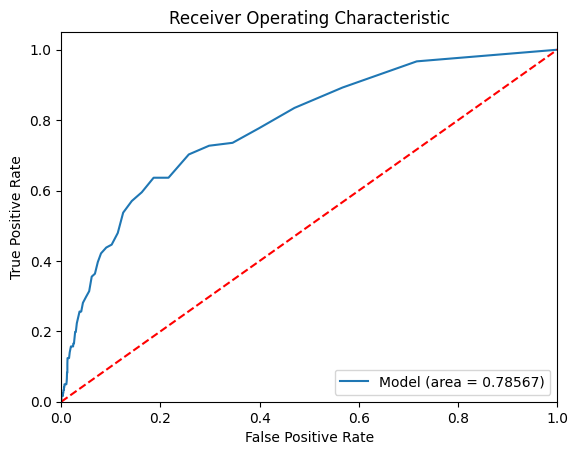

In [20]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
evaluate_model(forest, X_train, y_train, X_valid, y_valid)

### Max-Depth Random Forest

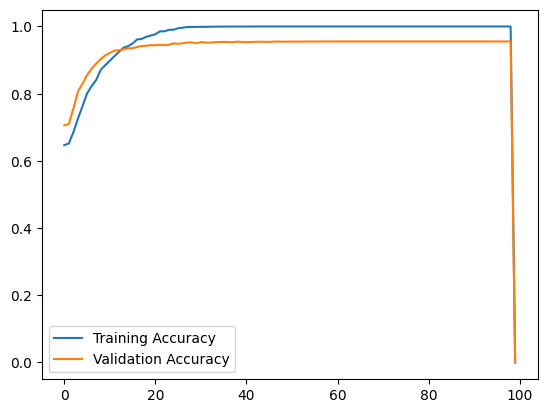

In [21]:
forest_trainaccuracy = np.zeros(shape=(100))
forest_validaccuracy = np.zeros(shape=(100))
for max_d in range(1,100):
  rf = RandomForestClassifier(max_depth=max_d, random_state=42)
  rf.fit(X_train,y_train)
  forest_trainaccuracy[max_d - 1]= rf.score(X_train, y_train)
  forest_validaccuracy[max_d - 1]= rf.score(X_valid, y_valid)

depths = range(0, 100)

# Plot and label the training and validation loss values
plt.plot(depths, forest_trainaccuracy, label='Training Accuracy')
plt.plot(depths, forest_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

54
Accuracy on validation set: 0.95514080
True Neg: 2912 	 False Pos: 21
False Neg: 116 	 True Pos: 5
Precision on validation set: 0.19230769
Recall on validation set: 0.04132231
F1-Score on validation set: 0.06802721


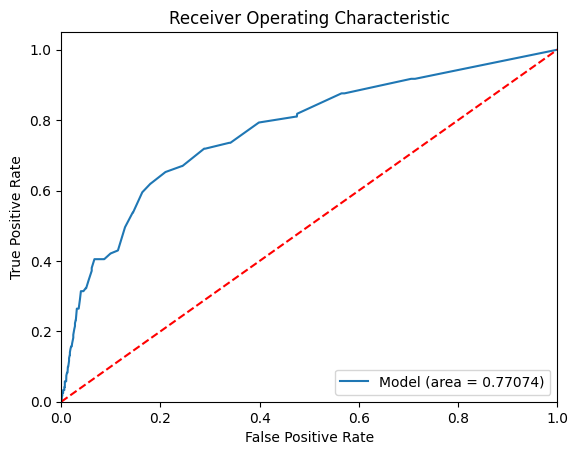

In [22]:
# max_depth = sqrt(d)
d = forest_validaccuracy.argmax(axis=0) + 1
print(d)
rf_depth = RandomForestClassifier(max_depth=d)
evaluate_model(rf_depth, X_train, y_train, X_valid, y_valid)

### Random Forest Grid Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

In [ ]:
rf_cvgrid = RandomForestClassifier(max_features=3, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=200)
evaluate_model(rf_cvgrid, X_train, y_train, X_valid, y_valid)

### Random Forest Randomized Search CV

In [ ]:
from numpy.random import randint

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':np.arange(1,7, step=1),
              'criterion':['gini','entropy'],
              'min_samples_leaf':np.arange(1,4,step=1),
              'min_samples_split':np.arange(2, 10, step=2)
          }

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   rs_space)

In [ ]:
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

In [ ]:
rf_rscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
evaluate_model(rf_rscv, X_train, y_train, X_valid, y_valid)

## KNN

Accuracy on validation set: 0.88081205
True Neg: 2652 	 False Pos: 281
False Neg: 83 	 True Pos: 38
Precision on validation set: 0.11912226
Recall on validation set: 0.31404959
F1-Score on validation set: 0.17272727


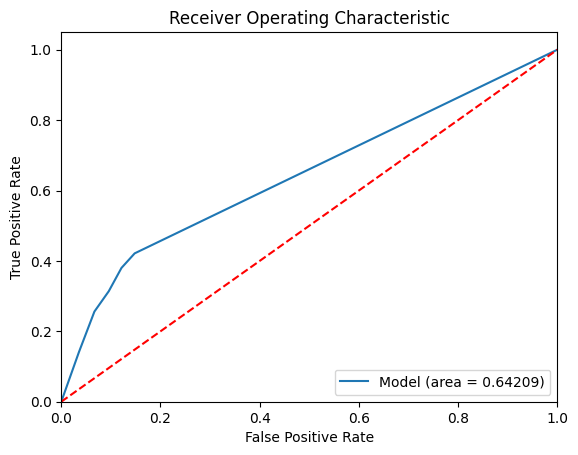

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, y_train, X_valid, y_valid)

### KNN: k values

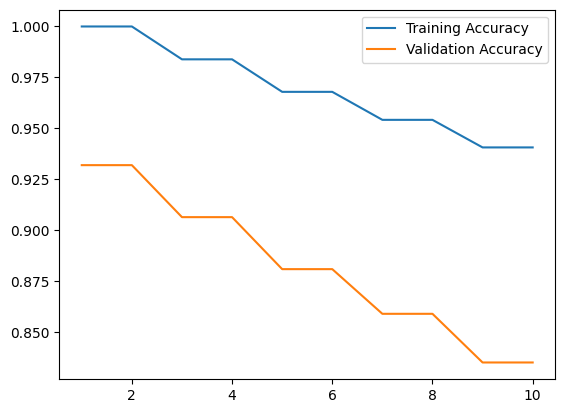

In [24]:
kn_trainaccuracy = np.zeros(10)
kn_validaccuracy = np.zeros(10)
for k in range(1,11):
  kn = KNeighborsClassifier(n_neighbors=k)
  kn.fit(X_train,y_train)
  kn_trainaccuracy[k-1]= kn.score(X_train, y_train)
  kn_validaccuracy[k-1]= kn.score(X_valid, y_valid)

depths = range(1, 11)

# Plot and label the training and validation loss values
plt.plot(depths, kn_trainaccuracy, label='Training Accuracy')
plt.plot(depths, kn_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

In [25]:
k = kn_validaccuracy.argmax(axis=0)
print(k)
knn_k = KNeighborsClassifier(n_neighbors=k)
evaluate_model(knn_k, X_train, y_train, X_valid, y_valid)

0


ValueError: Expected n_neighbors > 0. Got 0

### KNN: feature selection

In [ ]:
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(n_neighbors=4)

sfs1 = SFS(knn,
           k_features=3,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

sfs1 = sfs1.fit(X_train, y_train)


In [ ]:
print('Selected features:', sfs1.k_feature_idx_)
X_train_sfs = sfs1.transform(X_train)
X_valid_sfs = sfs1.transform(X_valid)
evaluate_model(knn, X_train_sfs, y_train, X_valid_sfs, y_valid)


## PCA/LDA/QDA/PLS

### PCA

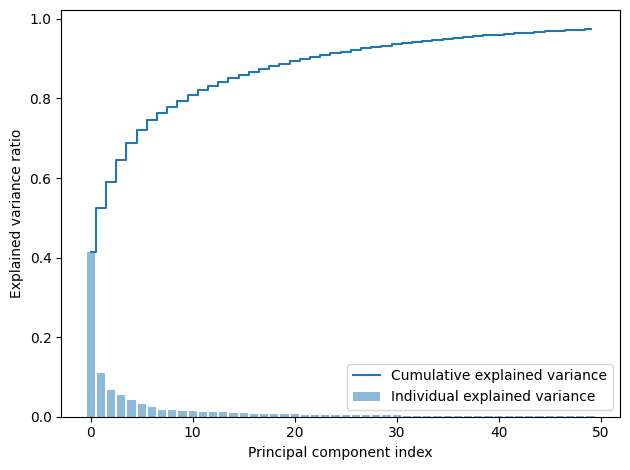

[0.41423133 0.11048414 0.06642684 0.0544155  0.04244648 0.03220525
 0.02546283 0.01755167 0.01644328 0.01472162 0.01326635 0.01234463
 0.01117282 0.01068195 0.00896556 0.00844932 0.0080345  0.00702413
 0.00660497 0.0063958  0.0058292  0.0054273  0.0051399  0.00478476
 0.00472518 0.00441088 0.0041576  0.00392612 0.00373187 0.00354574
 0.00311612 0.00304903 0.00294754 0.00276932 0.00253518 0.00237745
 0.00224985 0.0021273  0.00207595 0.00196587 0.00193003 0.00179454
 0.00177303 0.00173782 0.00168536 0.00159125 0.00127191 0.00126231
 0.00122381 0.00111665]


In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_valid)
pca_explained_variance = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(pca_explained_variance)
#
# Create the visualization plot
#
plt.bar(range(0,len(pca_explained_variance)), pca_explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(pca_explained_variance)

First component explains about 98% of the variance, second component about 1.4%

In [32]:
model_pca = PCA(n_components=9)
model_pca_X_train = model_pca.fit_transform(X_train)
model_pca_X_valid = model_pca.transform(X_valid)

Accuracy on validation set: 0.78781925
True Neg: 2332 	 False Pos: 601
False Neg: 47 	 True Pos: 74
Precision on validation set: 0.10962963
Recall on validation set: 0.61157025
F1-Score on validation set: 0.18592965


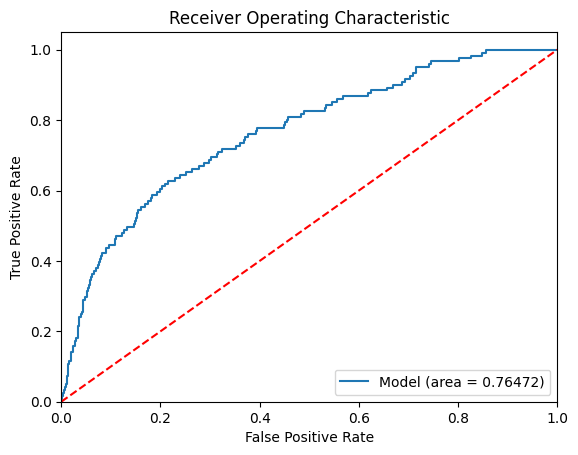

In [33]:
pca_logReg = LogisticRegression()
evaluate_model(pca_logReg, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Accuracy on validation set: 0.94924689
True Neg: 2895 	 False Pos: 38
False Neg: 117 	 True Pos: 4
Precision on validation set: 0.09523810
Recall on validation set: 0.03305785
F1-Score on validation set: 0.04907975


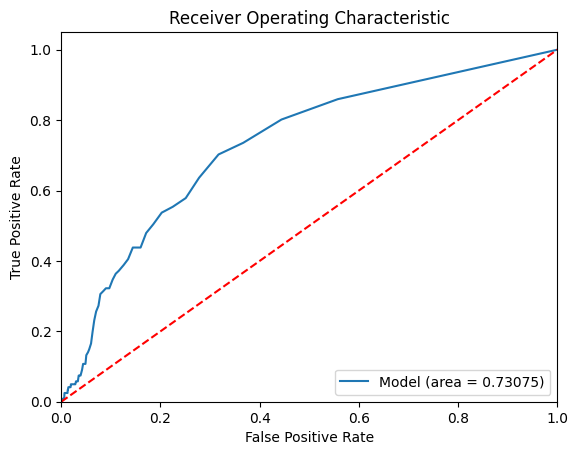

In [34]:
pca_tree = RandomForestClassifier()
evaluate_model(pca_tree, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Performs more poorly

Accuracy on validation set: 0.87557302
True Neg: 2635 	 False Pos: 298
False Neg: 82 	 True Pos: 39
Precision on validation set: 0.11572700
Recall on validation set: 0.32231405
F1-Score on validation set: 0.17030568


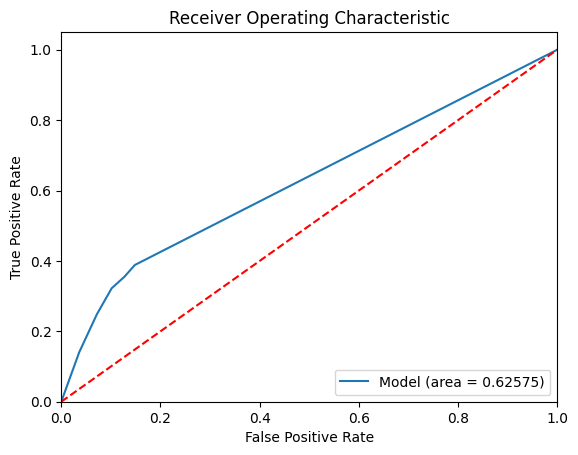

In [35]:
pca_knn = KNeighborsClassifier()
evaluate_model(pca_knn, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

### LDA

Accuracy on validation set: 0.77734119
True Neg: 2300 	 False Pos: 633
False Neg: 47 	 True Pos: 74
Precision on validation set: 0.10466761
Recall on validation set: 0.61157025
F1-Score on validation set: 0.17874396


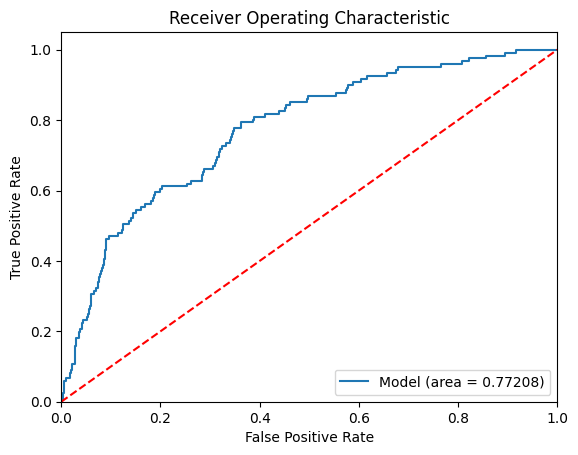

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
evaluate_model(lda, X_train, y_train, X_valid, y_valid)

### QDA

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy on validation set: 0.11165684
True Neg: 235 	 False Pos: 2698
False Neg: 15 	 True Pos: 106
Precision on validation set: 0.03780314
Recall on validation set: 0.87603306
F1-Score on validation set: 0.07247863


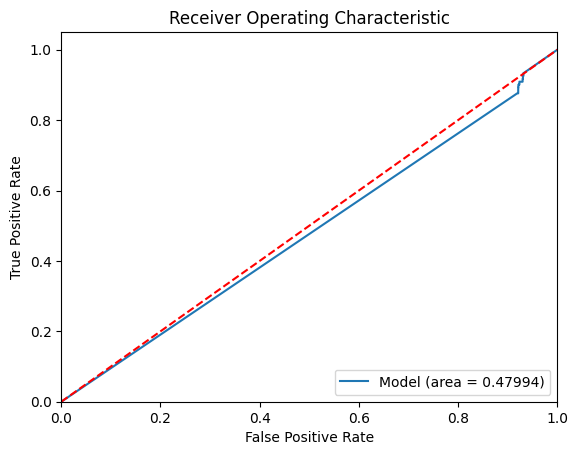

In [37]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
evaluate_model(qda, X_train, y_train, X_valid, y_valid)

### PLS

In [38]:
from sklearn.cross_decomposition import PLSRegression
pls_binary = PLSRegression(n_components=2)
pls_binary.fit(X_train, y_train)

pls_ypred_raw = pls_binary.predict(X_valid)[:,0]
pls_ypred = (pls_binary.predict(X_valid)[:,0] > 0.5).astype('uint8')

print('Precision of PLS-DA classifier on test set: {:.2f}'.format(accuracy_score(y_valid, pls_ypred)))
print('Precision of PLS-DA classifier on test set: {:.2f}'.format(precision_score(y_valid, pls_ypred)))
print('Recall of PLS-DA classifier on test set: {:.2f}'.format(recall_score(y_valid, pls_ypred)))

Precision of PLS-DA classifier on test set: 0.73
Precision of PLS-DA classifier on test set: 0.10
Recall of PLS-DA classifier on test set: 0.68


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!